In [1]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2_contingency
from cellrank.estimators import GPCCA
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.collections as collections 
import scanpy.external as sce
import matplotlib.collections as mc
import scrublet as scr
import cellrank as cr
import seaborn as sns
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import collections
import matplotlib
#import networkx
import anndata
#import network 
#import fsspec
#import igrap
import scvi
import desc
import umap
import sys
import h5py
import os
import re


#%load_ext rpy2.ipython
%matplotlib inline 


sc.settings.verbosity = 3     


# Setting the seed 
np.random.seed(42)


# Setting the figure parameters
sc.set_figure_params(figsize=(2.2, 2.2), format = 'svg', dpi_save = 300)

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


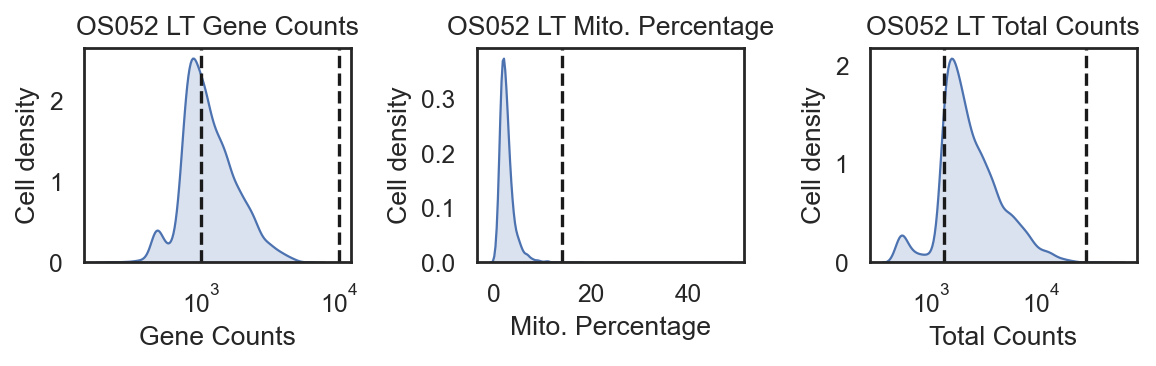

In [2]:
# Reading in H5 file
adata = sc.read_10x_mtx('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/public_data_analysis/zhou_data/BC2/')


# Making the var names unique
adata.var_names_make_unique()


# Annotating mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


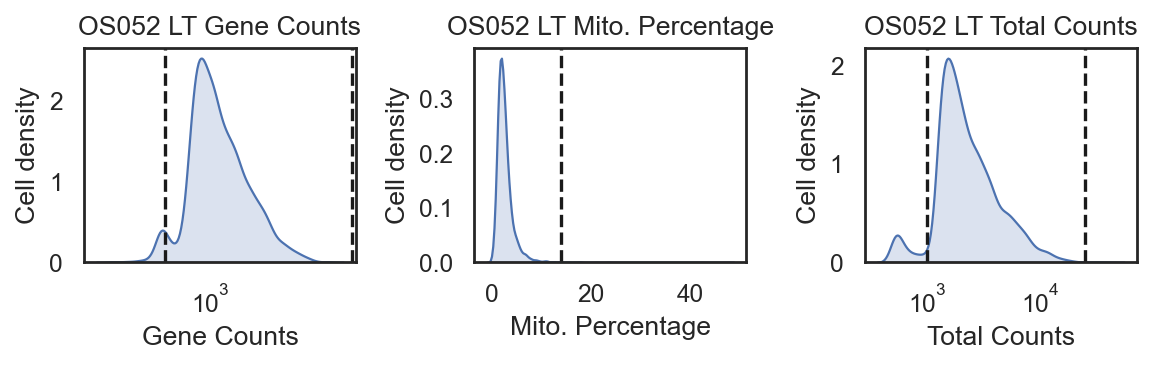

In [5]:


# Thresholds for QC plots
variables = [
    ('n_genes_by_counts', [(500, '--'), (9000, '--')]),
    ('pct_counts_mt', [(14, '--')]),
    ('total_counts', [(1000, '--'), (25000, '--')])
]


# Dictionary for new titles
titles = {
    'n_genes_by_counts': 'Gene Counts',
    'pct_counts_mt': 'Mito. Percentage',
    'total_counts': 'Total Counts'
}


# Setting the theme without gridlines
sns.set_theme(style="white")


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))


# Iterate over the variables and their respective lines to plot
for ax, (var, lines) in zip(axes, variables):
    sns.kdeplot(data=adata.obs, x=var, fill=True, alpha=0.2, ax=ax,
                log_scale=True if var != 'pct_counts_mt' else False)
    for line, style in lines:
        ax.axvline(x=line, color='k', linestyle=style)
    ax.set_title(f"OS052 LT {titles[var]}")  # Simpler title without extra text
    ax.set_xlabel(titles[var])  # Optionally keep the x-label as the new title
    ax.set_ylabel("Cell density")


# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure as SVG
#plt.savefig("/Users/brendamelano/Desktop/OS052_LT_filtering.svg")


# Show the plot
plt.show()


In [6]:


# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] <= 25000) &
              (adata.obs['total_counts'] >= 1000) &
                (adata.obs['n_genes_by_counts'] >= 500) &
                (adata.obs['n_genes_by_counts'] < 9000) & #pct_counts_mt
                (adata.obs['pct_counts_mt'] < 14)
                ]


# Normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# Make sure that the log transformation is where it belongs in this preprocessing sequence
scv.pp.log1p(adata)


# Preserving the counts
adata.layers["counts"] = adata.X.copy() 


# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000, # previously 3000
    subset=True,
    layer="counts"
)


#genes = adata.var.index.values


# reading in cell cycle genes in case I want to regress on that
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]


# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


# Keeping only the cell cycle genes within the adata object
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


# Computing the ccdifference scores
adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']


# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata

# Filtering the anndata object based on highly variable genes
adata = adata[:, adata.var.highly_variable]

# Regressing out counts, mitochondrial percentage and ccdifference scores
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)


# Computing principal components
sc.tl.pca(adata, svd_solver='arpack') #vary principal component number


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:554: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_count_corr"] = np.round(
/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_62742/1112347315.py:15: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)


Normalized count data: X.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html 

    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    514 total control genes are used. (0:00:00)
computing score 'G2M_score'


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added
    'G2M_score', score of gene set (adata.obs).
    470 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2167: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2084: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.prom

    finished (0:00:18)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


computing neighbors
    using 'X_pca' with n_pcs = 5
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


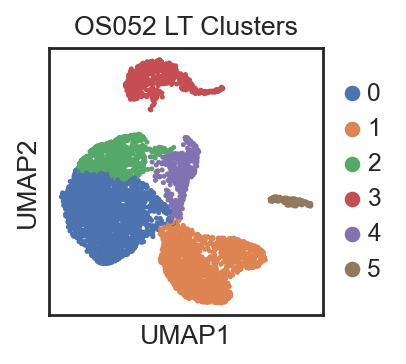

In [9]:

# Computing neighbors
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=5)


# Computing umap analysis
sc.tl.umap(adata)
# Leiden clustering
sc.tl.leiden(adata, resolution = 0.13)


# Plotting umap
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS052 LT Clusters",
    size = 20,
    #save="OS052_LT_Clusters.svg"
)

computing score 'State_A_score'
    finished: added
    'State_A_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)
computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    300 total control genes are used. (0:00:00)
computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    60 total control genes are used. (0:00:00)


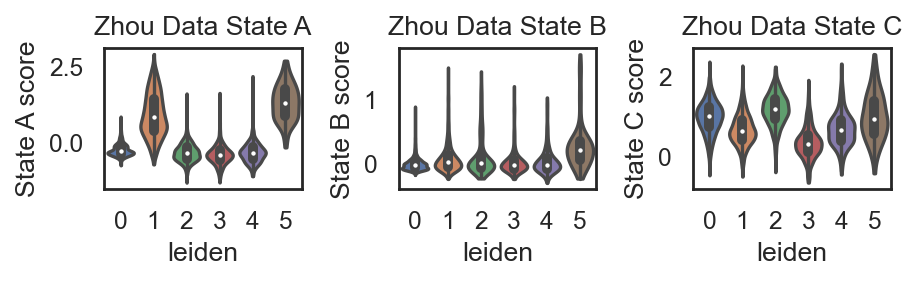

In [11]:
# Reading in gene lists for GSEA
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files/State_A_module_NMF.csv')]
Subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files/State_B_module_NMF.csv')]
Subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files/State_C_module_NMF.csv')]


# Keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]
Subtype_B_genes = [x for x in Subtype_B_genes if x in adata.var_names]
Subtype_C_genes = [x for x in Subtype_C_genes if x in adata.var_names]


# Computing GSEA scores
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, 
                  gene_pool=None, n_bins=25, 
                  score_name='State_A_score', random_state=0, copy=False, use_raw=None)

sc.tl.score_genes(adata, Subtype_B_genes, ctrl_size=50, 
                  gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)

sc.tl.score_genes(adata, Subtype_C_genes, ctrl_size=50, 
                  gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)


# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(5.7, 1.9))

sc.pl.violin(adata, ['State_A_score'], groupby='leiden', 
             stripplot=False, inner='box', 
             ylabel='State A score', ax=axs[0], show=False)


axs[0].set_title('Zhou Data State A')


sc.pl.violin(adata, ['Subtype_B_score'], groupby='leiden', 
             stripplot=False, inner='box', 
             ylabel='State B score', ax=axs[1], show=False)
axs[1].set_title('Zhou Data State B')

sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden', 
             stripplot=False, inner='box', 
             ylabel='State C score', ax=axs[2], show=False)
axs[2].set_title('Zhou Data State C')


plt.tight_layout()


# Saving the figure onto the desktop
plt.savefig('/Users/brendamelano/Desktop/OS152_gsea_scores.svg', format='svg')
plt.show()